# Air Pollution and Health Outcomes in US Cities: A Correlation Analysis

### Introduction to the project
This project investigates the relationship between air pollution levels and various health outcomes across cities in the United States. By combining ambient air quality data from the World Health Organization (WHO) with health statistics from the CDC's PLACES dataset, the analysis examines whether there are statistically significant correlations between air pollutants (particularly PM2.5 and PM10) and the prevalence of various health conditions.

### Hypothesis
The analysis addresses two primary hypotheses:
1. Prevelance of respiratory tract conditions have statistically significant positive correlation with air pollutants.
2. Overall quality of life metrics have statistically significant negative correlation with air pollutants.

### Methods
The analysis employs weighted Spearman correlation coefficients to account for non-normally distributed data and different population sizes across cities. Through comprehensive data processing, statistical testing, and visualization techniques, the project offers insights into how air pollution may be associated with specific health conditions in urban environments.

## Importing libraries

In [1]:
import pandas as pd
import matplotlib as plt
import numpy as np
from rapidfuzz import process, fuzz
import scipy.io
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import shapiro
import seaborn as sns
from weighted_spearman import weighted_spearman

## Reading and cleaning the datasets

### Base dataset

Ambient air quality data from World Health Organisation (WHO). The dataset has measurements for pm2.5, pm10 and NO2 levels for 7000 human settlements in 120 countries. We restrict the scope of this analysis to only include cities in the USA, since the most uniform health data for a large area we found was for the USA.

[link](https://www.who.int/publications/m/item/who-ambient-air-quality-database-(update-jan-2024))

In [2]:
# Read the air quality data
air_quality_df = pd.read_excel("who_ambient_air_quality_database_version_2024_(v6.1).xlsx", sheet_name="Update 2024 (V6.1)")

# Filter by US
air_quality_df = air_quality_df[air_quality_df["country_name"] == "United States of America"]

# Drop unnnecessary columns
air_quality_df = air_quality_df.drop(['country_name', 'version','reference','web_link', 'population_source','who_ms', 'type_of_stations', 'population', 'latitude', 'longitude', 'iso3', 'who_region', 'pm25_tempcov', 'pm10_tempcov','no2_tempcov'], axis=1)

# Remove state from city names
air_quality_df['city'] = air_quality_df['city'].str.split(' ').str[0]
air_quality_df['city'] = air_quality_df['city'].str.split('-').str[0]

# Leave only year 2020
air_quality_df = air_quality_df[air_quality_df['year'] == 2020.0]

air_quality_df.head()


,city,year,pm10_concentration,pm25_concentration,no2_concentration
99,Aberdeen,2020.0,NaN,NaN,NaN
243,Adrian,2020.0,NaN,8.20,NaN
502,Akron,2020.0,NaN,8.15,NaN
676,Albany,2020.0,NaN,9.10,NaN
688,Albany,2020.0,NaN,6.40,NaN


### Additional dataset

Statistics of different medical conditions in USA cities. The dataset includes different health measures, risk behaviours and preventive measures taken in different US cities. In the context of this analysis we are only interested in the health measures, so we remove all the irrelevant columns. However, we include smoking among adults for a reason we will discuss during the analysis of the results.

[link](https://data.cdc.gov/500-Cities-Places/PLACES-Local-Data-for-Better-Health-County-Data-20/duw2-7jbt/about_data)

In [3]:
# Read the health statistics data
health_statistic_df = pd.read_csv("PLACES_Local_Data_for_Better_Health_County_Data_2022_release_20250320.csv")

# We will use the age-adjusted data for the analysis to mitigate the impact of age distribution differences across cities
health_statistic_df = health_statistic_df[health_statistic_df["Data_Value_Type"].str.contains("Age", na=False)]

# Filter out cities with less than 100,000 population
health_statistic_df = health_statistic_df[health_statistic_df['TotalPopulation'] > 100000]

# Rename the city column
health_statistic_df = health_statistic_df.rename(columns={"LocationName": "city"})

# Drop unnecessary columns
health_statistic_df = health_statistic_df.drop(['StateAbbr', 'StateDesc', 'DataSource', 'Category', 'LocationID', 'CategoryID', 'DataValueTypeID', 'Geolocation', 'Low_Confidence_Limit', 'High_Confidence_Limit', 'Data_Value_Footnote_Symbol', 'MeasureId', 'Data_Value_Footnote' ], axis=1)

# First, let's identify the unique cities and measures
unique_cities = health_statistic_df['city'].unique()
unique_measures = health_statistic_df['Short_Question_Text'].unique()

# Create a pivot table with cities as index and measures as columns
health_df = health_statistic_df.pivot_table(
    index='city',
    columns='Measure',
    values='Data_Value',
    aggfunc='mean'  # Use mean if there are duplicate entries
)

population_df = health_statistic_df.groupby('city')['TotalPopulation'].first().reset_index()

# Reset the index to make 'city' a column again
health_df = health_df.reset_index()

# Drop columns that are not needed for the analysis
conditionsToDrop = [
'Current lack of health insurance among adults aged 18-64 years',
'Cervical cancer screening among adult women aged 21-65 years',
'Visits to dentist or dental clinic among adults aged >=18 years',
'Visits to doctor for routine checkup within the past year among adults aged >=18 years',
'Mammography use among women aged 50-74 years',
'Cholesterol screening among adults aged >=18 years',
'Older adult men aged >=65 years who are up to date on a core set of clinical preventive services: Flu shot past year, PPV shot ever, Colorectal cancer screening',
'Fecal occult blood test, sigmoidoscopy, or colonoscopy among adults aged 50-75 years',
'Older adult women aged >=65 years who are up to date on a core set of clinical preventive services: Flu shot past year, PPV shot ever, Colorectal cancer screening, and Mammogram past 2 years',
'All teeth lost among adults aged >=65 years',
'Arthritis among adults aged >=18 years',
'Binge drinking among adults aged >=18 years',
'Diagnosed diabetes among adults aged >=18 years',
'High cholesterol among adults aged >=18 years who have been screened in the past 5 years',
'No leisure-time physical activity among adults aged >=18 years',
'No leisure-time physical activity among adults aged >=18 years',
'Sleeping less than 7 hours among adults aged >=18 years',
'Stroke among adults aged >=18 years',
'Taking medicine for high blood pressure control among adults aged >=18 years with high blood pressure'
]
health_df = health_df.drop(conditionsToDrop, axis=1)

# All diseases
numberOfDiseases = len(list(health_statistic_df['Measure'].unique()))


health_df.head()

Measure,city,Cancer (excluding skin cancer) among adults aged >=18 years,Chronic kidney disease among adults aged >=18 years,Chronic obstructive pulmonary disease among adults aged >=18 years,Coronary heart disease among adults aged >=18 years,Current asthma among adults aged >=18 years,Current smoking among adults aged >=18 years,Depression among adults aged >=18 years,Fair or poor self-rated health status among adults aged >=18 years,High blood pressure among adults aged >=18 years,Mental health not good for >=14 days among adults aged >=18 years,Obesity among adults aged >=18 years,Physical health not good for >=14 days among adults aged >=18 years
0,Ada,5.90,2.40,4.8,5.10,9.8,13.3,20.50,10.70,27.3,13.00,27.70,8.6
1,Adams,5.75,2.55,5.9,5.55,10.0,16.8,20.45,12.75,26.8,14.85,31.85,9.6
2,Aiken,6.00,2.90,6.8,6.10,9.9,18.8,22.00,15.70,35.2,15.50,37.30,11.0
3,Alachua,5.80,3.00,7.2,6.20,9.3,16.4,18.60,15.30,30.9,15.90,31.90,10.9
4,Alamance,5.80,3.00,6.5,6.10,9.6,19.3,23.40,14.60,34.0,15.10,35.90,10.5


### Matching cities using rapidfuzz

Since the formatting of some city names is slightly different in the two datasets, using fuzzrapidfuzz allows us to keep more of the data than simple string matching. In this block we replace the city names in 'city' column of air_quality_df with the corresponding names from health_df so that we can merge them later.

In [4]:
def find_best_match_city(city, citylist, threshold=95):
    best_match, score, _ = process.extractOne(city, citylist, scorer=fuzz.ratio)
    return best_match if score >= threshold else city

air_quality_df['city'] = air_quality_df['city'].apply(lambda x: find_best_match_city(x, unique_cities))

### Merging the two based on the matched cities

Now we use the previously handled 'city' column to merge our datasets.

In [5]:
# Merge the dataframes on the 'city' column
# using inner join to keep only cities that are present in both dataframes
merged_df = pd.merge(health_df, air_quality_df, on='city', how='inner')

# Merge with population data
# using left join to keep all cities from merged_df
merged_df = pd.merge(merged_df, population_df, on='city', how='left')

# Drop duplicate cities, because the data contains multiple entries for the same city
merged_df = merged_df.drop_duplicates(subset='city', keep='first')

print("Columns with non-null values for:")
print(f"PM10 concentrations  - {merged_df['pm10_concentration'].notna().sum()}")
print(f"PM2.5 concentrations - {merged_df['pm25_concentration'].notna().sum()}")
print(f"NO2 concentrations   - {merged_df['no2_concentration'].notna().sum()}")

merged_df.head()

Columns with non-null values for:
PM10 concentrations  - 37
PM2.5 concentrations - 61
NO2 concentrations   - 30


,city,Cancer (excluding skin cancer) among adults aged >=18 years,Chronic kidney disease among adults aged >=18 years,Chronic obstructive pulmonary disease among adults aged >=18 years,Coronary heart disease among adults aged >=18 years,Current asthma among adults aged >=18 years,Current smoking among adults aged >=18 years,Depression among adults aged >=18 years,Fair or poor self-rated health status among adults aged >=18 years,High blood pressure among adults aged >=18 years,Mental health not good for >=14 days among adults aged >=18 years,Obesity among adults aged >=18 years,Physical health not good for >=14 days among adults aged >=18 years,year,pm10_concentration,pm25_concentration,no2_concentration,TotalPopulation
0,Albany,6.0,2.5,5.4,5.0,10.4,14.5,19.4,10.4,26.1,13.6,26.7,8.0,2020.0,NaN,9.100,NaN,303654
2,Alexandria,5.8,2.4,4.1,4.6,8.9,10.9,16.6,10.6,30.8,11.7,27.3,7.1,2020.0,NaN,7.300,NaN,158726
3,Anchorage,5.8,2.4,4.6,5.1,9.2,15.6,16.3,11.3,29.8,11.6,28.5,8.3,2020.0,9.767,5.250,NaN,287095
4,Atlantic,5.7,2.7,6.0,6.0,10.2,16.7,19.0,14.1,NaN,14.8,32.4,9.5,2020.0,NaN,6.500,NaN,262945
5,Baltimore,6.1,2.6,5.0,5.0,10.0,13.8,18.2,12.0,32.4,14.5,31.7,7.7,2020.0,10.000,6.575,22.2,826017


## Testing the normality of the data

Before we can look for correlations in the data, we need to test for the normality of the data to be able to use appropriate formula for the correlation. Hence, we perform the Shapiro-Wilk normality test, because it is best suited for datasets with medium to large sample sizes. After running the test, we conclude that some of the diseases appear to be non-normally distributed, therefore we must use a formula for correlation coefficient that is suitable for non-normal distributions.

In [6]:
array = merged_df.to_numpy()

p_values = []

# Get the column names for disease columns (skipping city, year, pollutants, and population)
disease_columns = merged_df.columns[1:13].tolist()
print(f"Testing normality for {len(disease_columns)} disease columns:")
print("-"*110)

# Run Shapiro-Wilk test for each disease column
for col_name in disease_columns:
    disease_data = merged_df[col_name].dropna().values
    
    stat, p_value = shapiro(disease_data)
    p_values.append(p_value)
    
    result = "Potentially normal" if p_value >= 0.05 else "Non-normal"
    
    print(f"{col_name:70} | {result:20} | p={p_value:.3f}")


# Count how many p-values are less than 0.05 (indicating non-normal distribution)
non_normal_count = sum(p < 0.05 for p in p_values)
print("-"*110)
col_name = "Potentially normal"
print(f"{col_name:70} | {len(p_values) - non_normal_count}")
col_name = "Non-normal"
print(f"{col_name:70} | {non_normal_count}")


Testing normality for 12 disease columns:
--------------------------------------------------------------------------------------------------------------
Cancer (excluding skin cancer) among adults aged >=18 years            | Non-normal           | p=0.000
Chronic kidney disease among adults aged >=18 years                    | Potentially normal   | p=0.114
Chronic obstructive pulmonary disease among adults aged >=18 years     | Potentially normal   | p=0.668
Coronary heart disease among adults aged >=18 years                    | Potentially normal   | p=0.260
Current asthma among adults aged >=18 years                            | Potentially normal   | p=0.063
Current smoking among adults aged >=18 years                           | Potentially normal   | p=0.458
Depression among adults aged >=18 years                                | Potentially normal   | p=0.538
Fair or poor self-rated health status among adults aged >=18 years     | Potentially normal   | p=0.217
High blood pres

## Weighted spearman's correlation matrix

We use spearman's correlation, because it's well suited for non-normally distributed data. Additionally we use the populations of the cities as weights to take into account differently sized cities.

### Creating the correlation and p-value matrixes

Here we create the correlation matrix which includes the correlation coefficient for each pollutant-disease pair. We also create a corresponding p-value matrix, since calculating the p-value for weighted spearman's correlation afterwards is hard.

In [7]:
# Pollutant columns, we choose to exlude NO2 here, since there was less data on that one then the other
# pollutants, and the relaibility of the data appeared to be worse, since the measurements were less frequent.
pollutants = ['pm10_concentration', 'pm25_concentration']

disease_columns = [col for col in health_df.columns if col != 'city']

# Create a correlation matrix between pollutants and diseases
correlation_matrix = pd.DataFrame(index=disease_columns, columns=pollutants)

# Create corresponding p-value matrix for the correlations
p_value_matrix = pd.DataFrame(index=disease_columns, columns=pollutants)

# Extract weights (population values)
weights = merged_df['TotalPopulation']

# Calculate weighted correlation for each pollutant-disease pair
for disease in disease_columns:
    for pollutant in pollutants:
        # Extract the data
        data_disease = merged_df[disease]
        data_pollutant = merged_df[pollutant]
        
        # Create mask for non-NaN values in both columns
        mask = ~data_disease.isna() & ~data_pollutant.isna()
        
        
        # Calculate weighted correlation using the function
        corr_value, p_value = weighted_spearman(
            data_disease[mask].values, 
            data_pollutant[mask].values, 
            weights[mask].values
        )
        correlation_matrix.loc[disease, pollutant] = corr_value
        p_value_matrix.loc[disease, pollutant] = p_value


### Displaying correlation matrix without p-values

We generate the correlation matrix between airpollutants and medical conditions, since it is the easiest way to get a comprehensive view of all the correlations. 

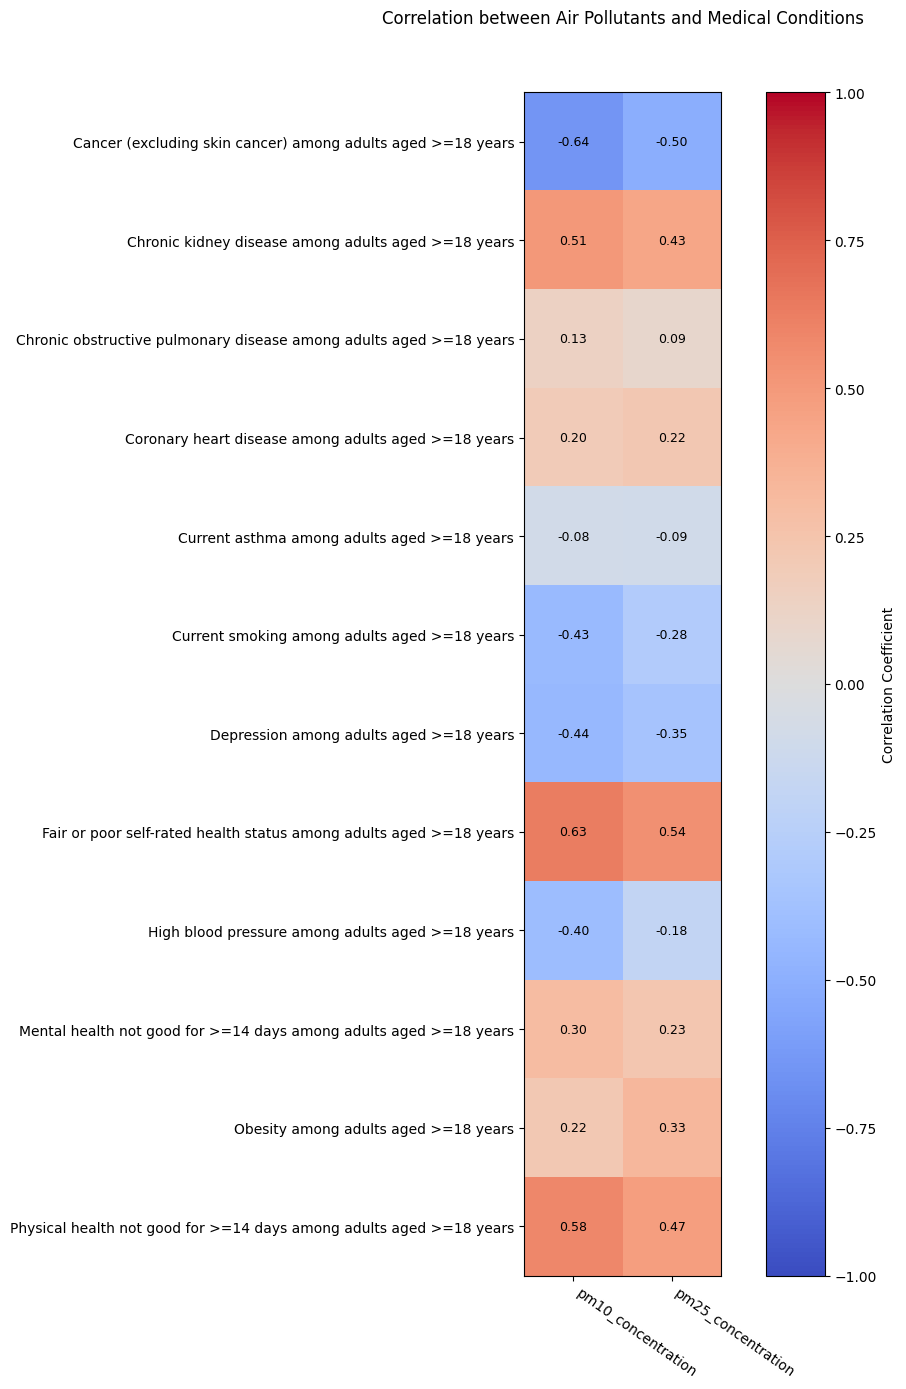

In [8]:
# Extract and transpose the correlation matrix - diseases as rows and pollutants as columns
disease_pollutant_corr = correlation_matrix.loc[disease_columns, pollutants]

# Visualize the correlation matrix as a heatmap using matplotlib
plt.figure(figsize=(10, 14))

# Convert correlation values to float
disease_pollutant_corr = disease_pollutant_corr.astype(float)

# Create the heatmap
im = plt.imshow(disease_pollutant_corr, cmap='coolwarm', vmin=-1, vmax=1)

# Add colorbar
cbar = plt.colorbar(im)
cbar.set_label('Correlation Coefficient')

# Add labels and title
plt.title('Correlation between Air Pollutants and Medical Conditions', pad=50)
plt.xticks(np.arange(len(pollutants)), pollutants, rotation=-35, ha='left')
plt.yticks(np.arange(len(disease_columns)), disease_columns, rotation=0)  # Changed rotation to 0

# Add correlation values as text annotations
for i in range(len(disease_columns)):
    for j in range(len(pollutants)):
        corr_value = disease_pollutant_corr.iloc[i, j]
        
        # Format the correlation value
        if pd.notna(corr_value):
            corr_text = f'{corr_value:.2f}'
            plt.text(j, i, corr_text, ha="center", va="center", color="black", fontsize=9)

plt.tight_layout()
plt.show()


### Dislaying correlation matrix with p-values and conclusions from the graph


Now we generate the correlation matrix with the corresponding p-values to better understand the results. Correlations that are not statistically significant with 5% significanse level are grayed out.

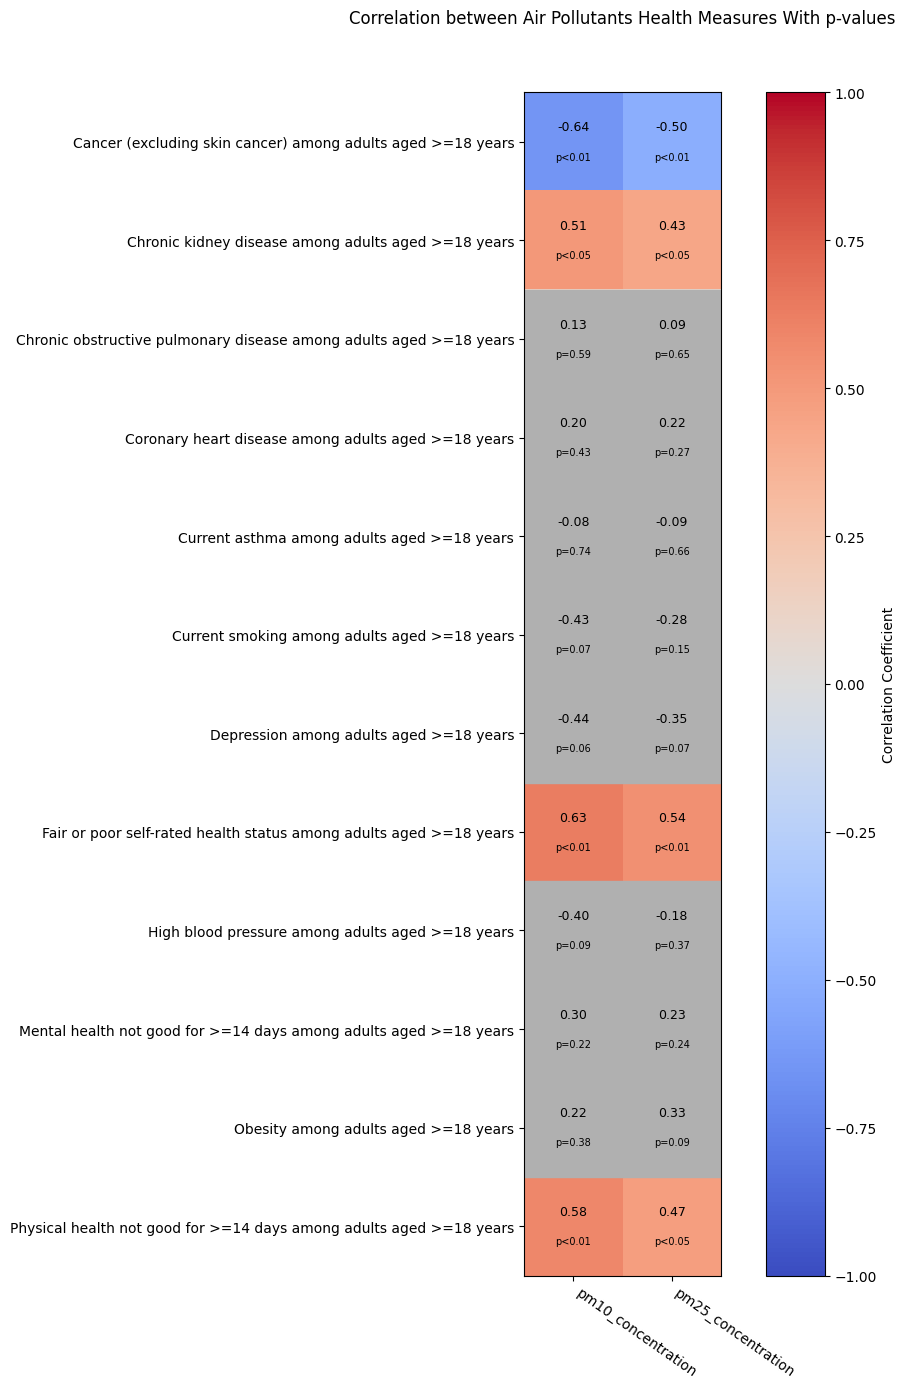

In [9]:
plt.figure(figsize=(10, 14))

# Create the heatmap
im = plt.imshow(disease_pollutant_corr, cmap='coolwarm', vmin=-1, vmax=1)

# Add colorbar
cbar = plt.colorbar(im)
cbar.set_label('Correlation Coefficient')

# Add labels and title
plt.title('Correlation between Air Pollutants Health Measures With p-values', pad=50)
plt.xticks(np.arange(len(pollutants)), pollutants, rotation=-35, ha='left')
plt.yticks(np.arange(len(disease_columns)), disease_columns, rotation=0)

ax = plt.gca()  # Get the current axis

# Add correlation values, p-values, and light gray overlay
for i in range(len(disease_columns)):
    for j in range(len(pollutants)):
        corr_value = disease_pollutant_corr.iloc[i, j]
        p_value = p_value_matrix.iloc[i, j]
        
        # Format the correlation value
        corr_text = f'{corr_value:.2f}'
        
        # Format the p-value
        if pd.notna(p_value):
            if p_value < 0.001:
                p_text = 'p<0.001'
            elif p_value < 0.01:
                p_text = 'p<0.01'
            elif p_value < 0.05:
                p_text = 'p<0.05'
            else:
                p_text = f'p={p_value:.2f}'
        else:
            p_text = 'p=NA'

        # Add text annotations
        plt.text(j, i - 0.15, corr_text, ha="center", va="center", color="black", fontsize=9)
        plt.text(j, i + 0.15, p_text, ha="center", va="center", color="black", fontsize=7)

        # Add light gray overlay if p-value >= 0.05
        if p_value >= 0.05:
            rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color='#B0B0B0')  # Light gray
            ax.add_patch(rect)

plt.tight_layout()
plt.show()

#### Conclusionds from the graph

- Prevalence of neither asthma nor chronic obstructive pulmonary disease have significant correlation with the pollution levels, even though both are respiratory track conditions. Our 1st hypothesis seems to not hold true.

- 'Physical health not good for >= 14 days amon adults' and 'Fair or poor self-rated health status among adults' seem to positively correlate with both pm10 and pm25 pollution levels, meaning that the overall health of individuals seems to negatively correlate with air pollution. Our 2nd hypothesis seems to hold true.

- Prevalence of cancer among adults seems to negatively correlate with pollution levels, which seems counter intuitive. For this reason, we wanted to include current smoking among adults in the results, since at least in within the scope of our data it seemed to negatively correlate with air pollution levels, and as a known predictor for cancer it could partially explain the result. Hence it could be one hidden variable contributing to this correlation, but the scope of this analysis isn't wide enough to make any conclusions for that. Here it is important to remember that correlation and causation are distinct.

- Prevelance of chronic kidney disease appears to have positive correlation with air pollutants.

### Sample scatter plots for the data

C:\Users\anssi\AppData\Local\Temp\ipykernel_3560\137299110.py:41: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


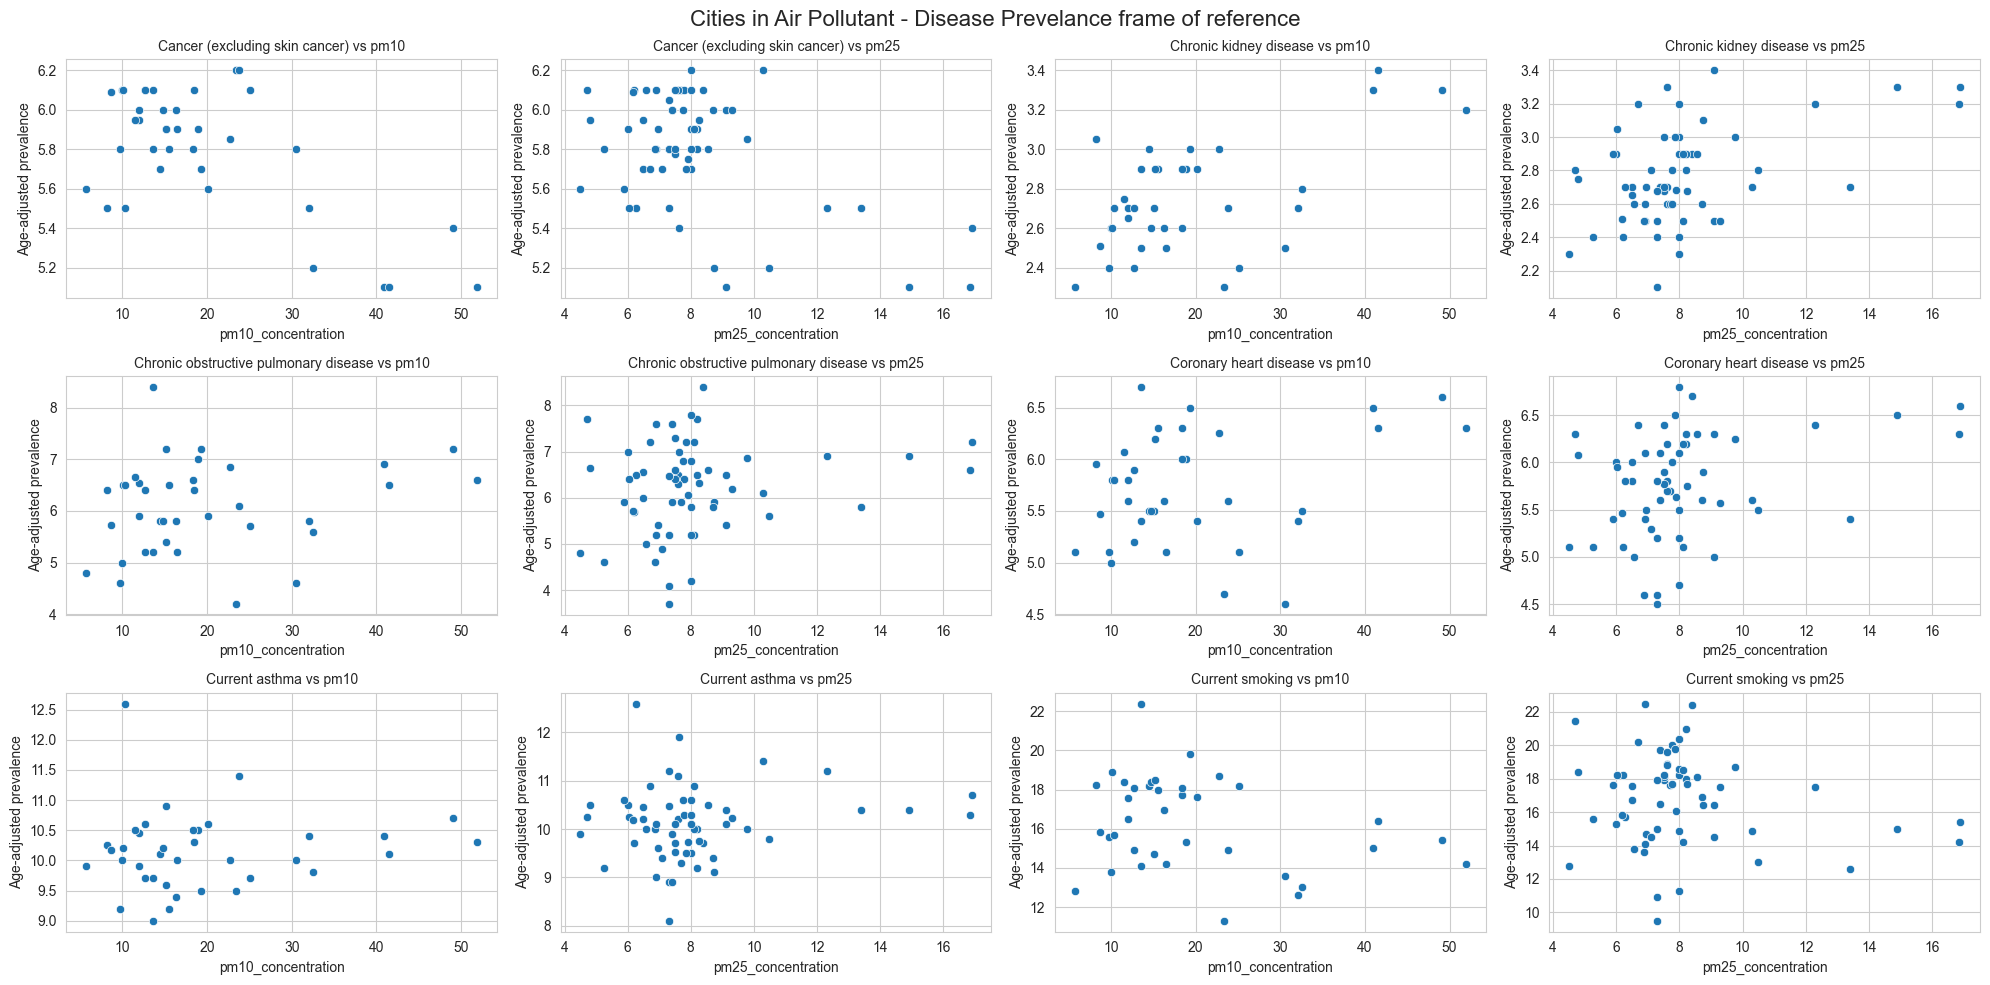

In [10]:
# Set seaborn style
sns.set_style("whitegrid")

# Use the original merged_df, and include all disease columns
all_disease_columns = [col for col in merged_df.columns if "among adults aged" in col]
pollutant_columns = ["pm10_concentration", "pm25_concentration"]

# Create a 3x4 grid of subplots with specified figure size
fig, axes = plt.subplots(3, 4, figsize=(20, 10), constrained_layout=True)
axes = axes.flatten()  # Flatten to make indexing easier

# Keep track of the current subplot
plot_index = 0

# Iterate through diseases and pollutants to create scatter plots
for disease in all_disease_columns:
    for pollutant in pollutant_columns:
        # Skip if we've run out of subplots
        if plot_index >= len(axes):
            break
            
        ax = axes[plot_index]  # Select the current subplot
        plot_index += 1
        
        # Create scatter plot in the current subplot (no regression line)
        sns.scatterplot(data=merged_df, x=pollutant, y=disease, ax=ax)
        
        # Set labels and titles
        ax.set_xlabel(pollutant)
        ax.set_ylabel('Age-adjusted prevalence')
        
        # Create a shorter title
        disease_short = disease.replace(" among adults aged >=18 years", "")
        pollutant_short = pollutant.replace("_concentration", "")
        ax.set_title(f"{disease_short} vs {pollutant_short}", fontsize=10)


# Add a main title
fig.suptitle('Cities in Air Pollutant - Disease Prevelance frame of reference', fontsize=16)

plt.tight_layout()
plt.show()

### Creating scatter plots of cities for the air pollutant-medical condition pairs that had statistically significant correlations

C:\Users\anssi\AppData\Local\Temp\ipykernel_3560\98361476.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  columns_with_insignificant_values = [disease_columns[i] for i in range(len(disease_columns)) if invalid_rows[i]]


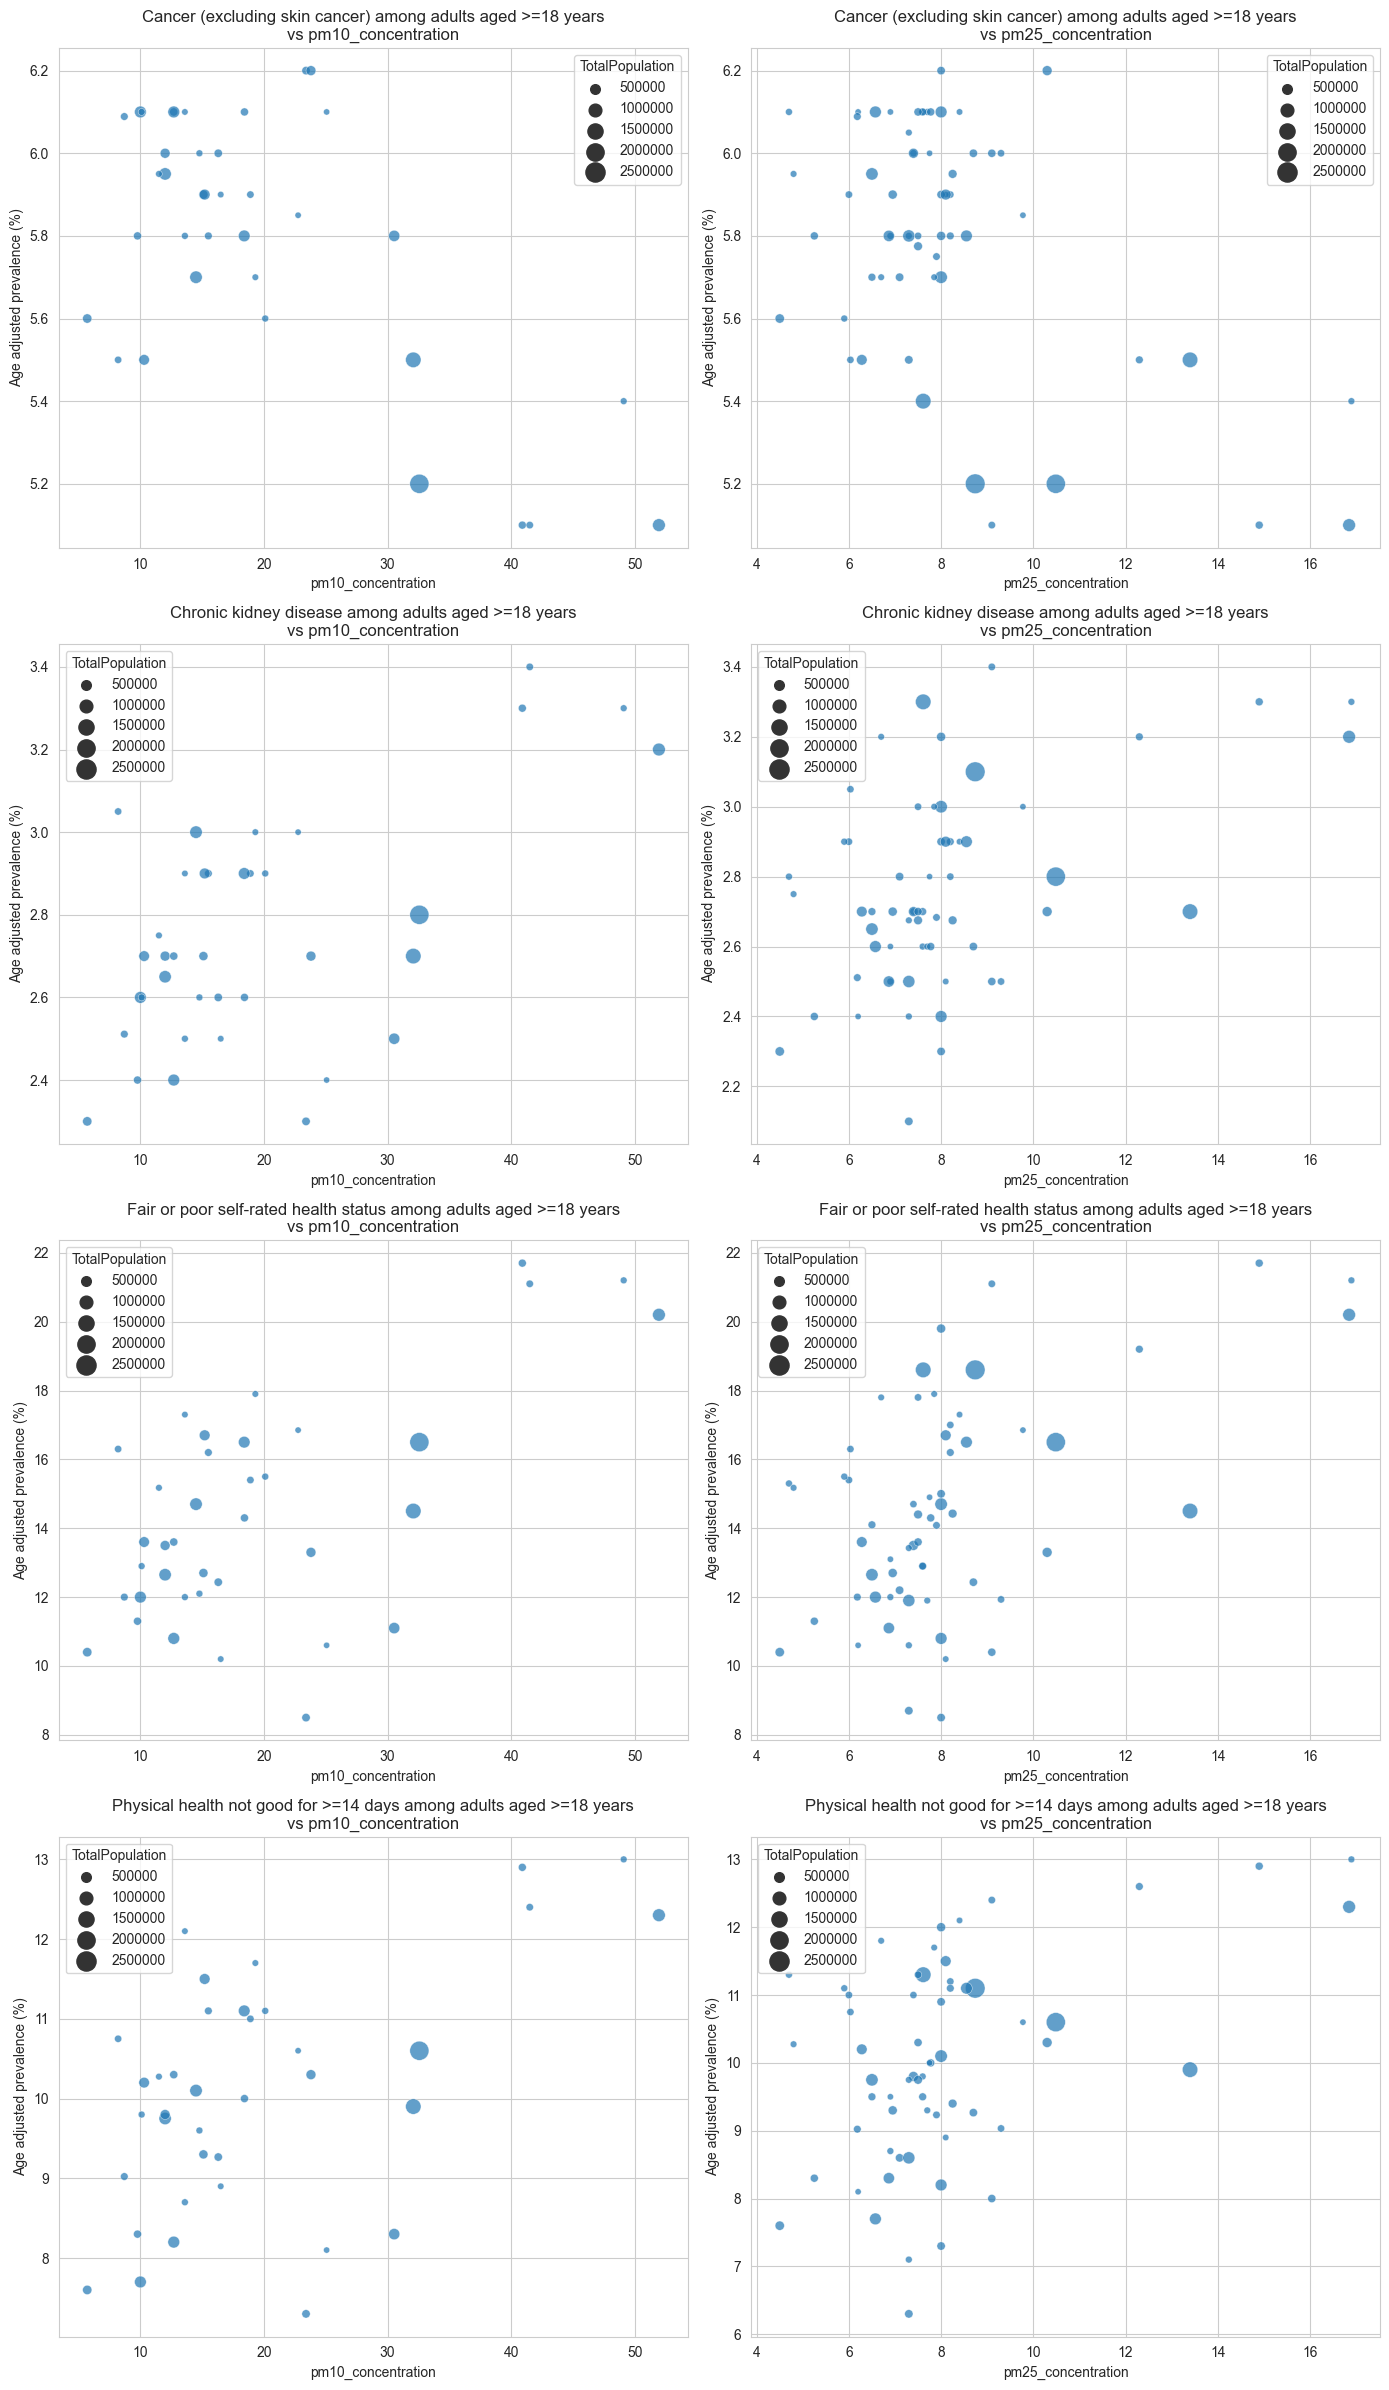

In [ ]:
# First, let's handle the filtering of correlations without modifying disease_columns
insignificant_mask = p_value_matrix > 0.05
ins_filtered_correlations = correlation_matrix.copy()
ins_filtered_correlations = ins_filtered_correlations.where(insignificant_mask, np.nan)
ins_filtered_correlations = ins_filtered_correlations.astype(float)  # Ensure numeric dtype

# Get the columns that have insignificant p-values
invalid_rows = insignificant_mask.any(axis=1)

# Get the disease names corresponding to these rows (assuming correlation_matrix has disease names as index)
columns_with_insignificant_values = [disease_columns[i] for i in range(len(disease_columns)) if invalid_rows[i]]


# Make a copy of merged_df
merged_df_copy = merged_df.copy()

# Drop columns with insignificant values
merged_df_copy = merged_df_copy.drop(columns_with_insignificant_values, axis=1, errors='ignore')

pollutant_columns = ["pm10_concentration", "pm25_concentration"]

# Set seaborn style
sns.set_style("whitegrid")

# Create scatter plots only for diseases that exist in the dataframe
# Create a figure with subplots in a 4x2 grid (one for each disease-pollutant combination)
fig, axes = plt.subplots(4, 2, figsize=(14, 24))

# Flatten to make indexing easier
axes = axes.flatten()

# Track which plots we've created
plot_count = 0

# Create scatter plots for the specified diseases
for i, disease in enumerate(disease_columns):
    if disease in merged_df_copy.columns:
        for j, pollutant in enumerate(pollutant_columns):
            # Create the scatter plot in the appropriate subplot position
            ax = axes[plot_count]
            
            # Create scatter plot with population-sized markers
            scatter = sns.scatterplot(
                data=merged_df_copy,
                x=pollutant,
                y=disease,
                size="TotalPopulation",
                sizes=(20, 200),
                alpha=0.7,
                ax=ax
            )
            
            # Add a trend line
            sns.regplot(
                data=merged_df_copy,
                x=pollutant, 
                y=disease,
                scatter=False,
                ci=95,
                line_kws={'color': 'red'},
                ax=ax
            )
            
            ax.set_xlabel(f"{pollutant}", fontsize=10)
            ax.set_ylabel('Age adjusted prevalence (%)', fontsize=10)
            ax.set_title(f"{disease}\nvs {pollutant}", fontsize=12)
            plot_count += 1
    else:
        pass

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

## Visualising p-values for the correlation coefficients

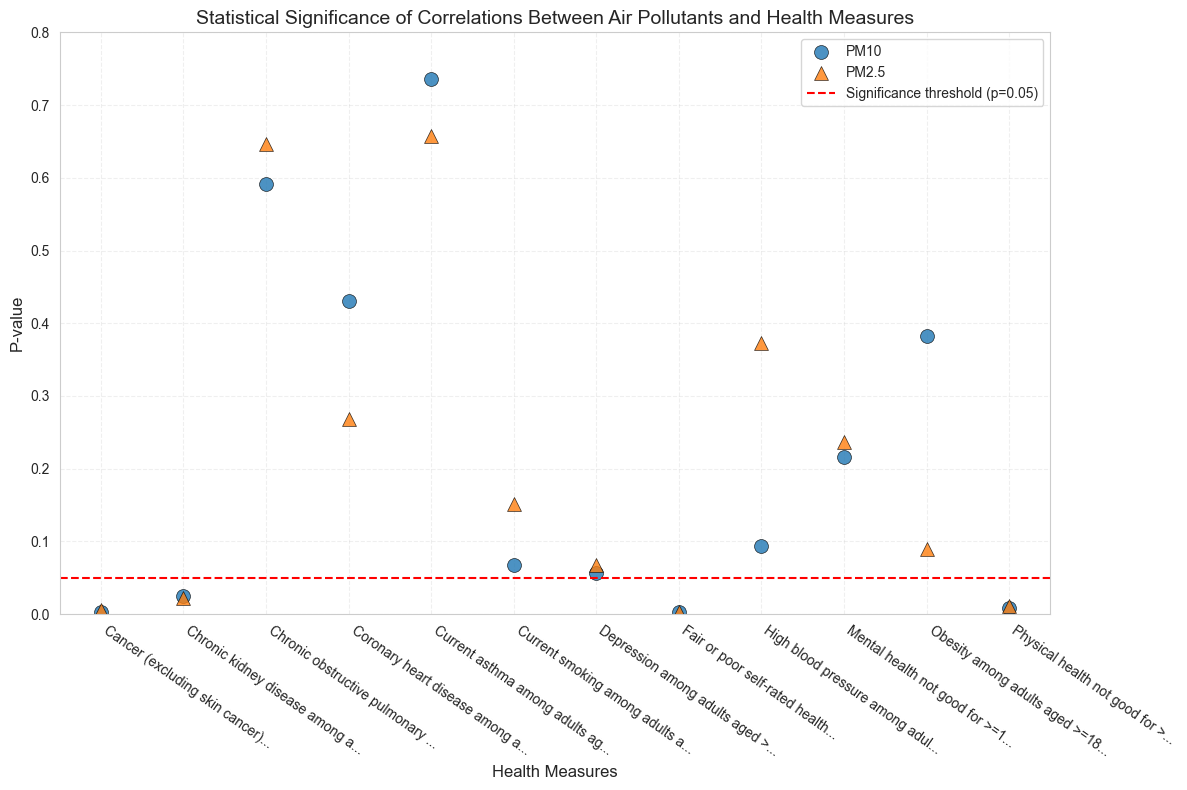

In [12]:
# Create a more readable visualization of p-values with disease names
# First, let's create a dataframe that maps disease indices to actual disease names
disease_names = {
    i+1: name for i, name in enumerate(disease_columns)
}

# Convert p-values to a dataframe for easier plotting
p_values_df = pd.DataFrame(p_value_matrix)

# Create a figure with better formatting
plt.figure(figsize=(12, 8))

# Set up colors for different pollutants
colors = ['#1f77b4', '#ff7f0e']
markers = ['o', '^']
labels = ['PM10', 'PM2.5']

# Create the scatter plot with a clearer layout - plot ALL points
for j in range(p_values_df.shape[1]):
    x_values = np.array(range(1, len(p_values_df) + 1))
    y_values = p_values_df.iloc[:, j]
    
    # Plot all points
    plt.scatter(x_values, y_values, 
                color=colors[j], 
                marker=markers[j],
                s=100,  # Larger point size
                alpha=0.8,
                edgecolors='black',
                linewidths=0.5,
                label=labels[j])

# Add significance threshold line
plt.axhline(y=0.05, color='red', linestyle='--', linewidth=1.5, label='Significance threshold (p=0.05)')

# Improve the x-axis presentation - rotate labels for readability
plt.xticks(range(1, len(disease_names) + 1), 
           [disease[:30] + '...' if len(disease) > 20 else disease for disease in disease_names.values()],
           rotation=-35, ha='left')

plt.xlim(0.5, len(disease_names) + 0.5)
plt.ylim(0, 0.8)  # Set y-axis limit to show all points

# Add labels and title
plt.xlabel('Health Measures', fontsize=12)
plt.ylabel('P-value', fontsize=12)
plt.title('Statistical Significance of Correlations Between Air Pollutants and Health Measures', fontsize=14)

# Add a legend
plt.legend(loc='upper right', frameon=True)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

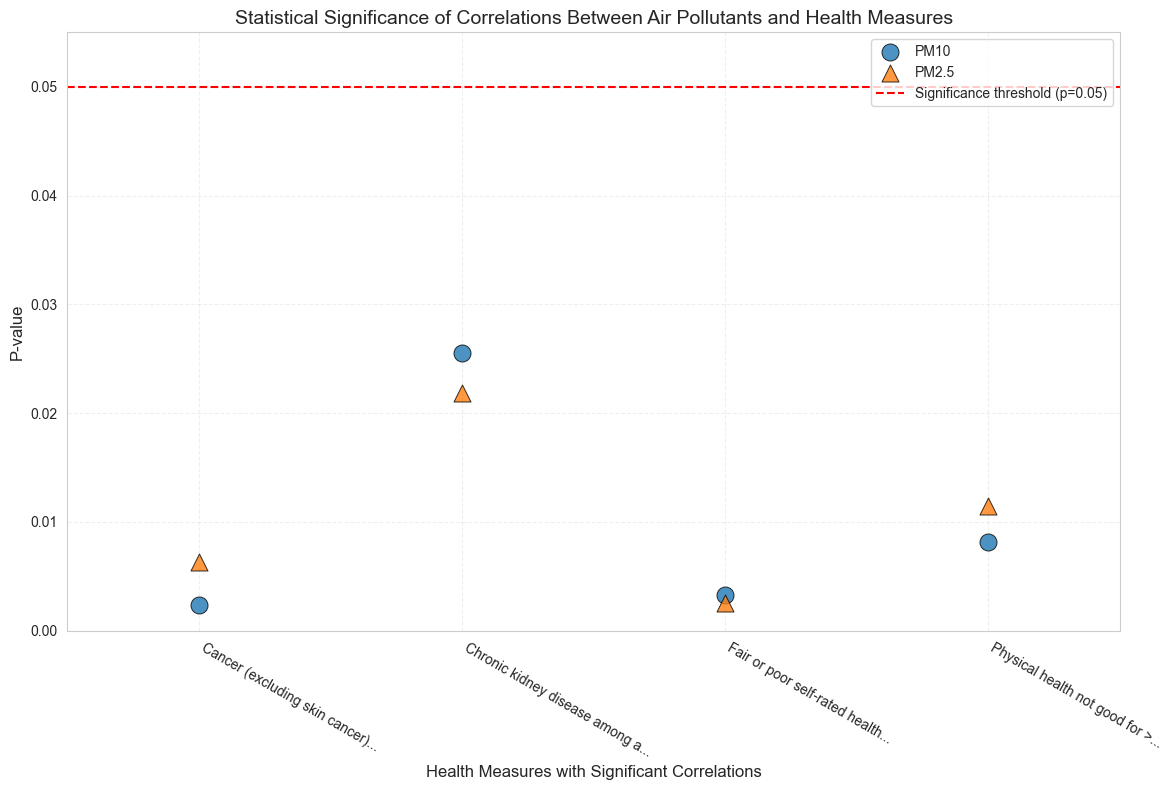

In [13]:
# Create a more readable visualization of significant p-values with disease names

# First, create a mask for significant p-values (p < 0.05)
significant_mask = p_value_matrix < 0.05

# Get the indices of diseases with significant correlations
significant_diseases = []
for i, row in enumerate(significant_mask.index):
    if significant_mask.loc[row].any():
        significant_diseases.append(i+1)

# Get the names of these significant diseases
significant_disease_names = [disease_columns[i-1] for i in significant_diseases]

# Create shortened labels for plotting
significant_disease_labels = [name[:30] + '...' if len(name) > 30 else name for name in significant_disease_names]

# Create a figure with better formatting
plt.figure(figsize=(12, 8))

# Set up colors for different pollutants
colors = ['#1f77b4', '#ff7f0e']  # Only 2 colors for PM10 and PM2.5
markers = ['o', '^']  # Only 2 markers
labels = ['PM10', 'PM2.5']  # Only include PM10 and PM2.5

# Plot only the significant p-values
for j in range(p_values_df.shape[1]):
    # Focus only on diseases with significant p-values
    for i, disease_idx in enumerate(significant_diseases):
        disease_name = significant_disease_names[i]
        if significant_mask.loc[disease_name, p_values_df.columns[j]]:
            plt.scatter(i+1, p_values_df.loc[disease_name, p_values_df.columns[j]], 
                    color=colors[j], 
                    marker=markers[j],
                    s=150,  # Larger point size
                    alpha=0.8,
                    edgecolors='black',
                    linewidths=0.7,
                    label=labels[j] if i == 0 else "")  # Only label once for each pollutant

# Add significance threshold line
plt.axhline(y=0.05, color='red', linestyle='--', linewidth=1.5, label='Significance threshold (p=0.05)')

# Improve the x-axis presentation
plt.xticks(range(1, len(significant_disease_labels) + 1), 
           significant_disease_labels,
           rotation=-30, ha='left')

plt.xlim(0.5, len(significant_disease_labels) + 0.5)
plt.ylim(0, 0.055)  # Set y-axis limit just above significance level

# Add labels and title
plt.xlabel('Health Measures with Significant Correlations', fontsize=12)
plt.ylabel('P-value', fontsize=12)
plt.title('Statistical Significance of Correlations Between Air Pollutants and Health Measures', fontsize=14)

# Add a legend with unique entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper right', frameon=True)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()
